In [ ]:
import os

def parse_time(time_str):
    if time_str[-2:] == "us":
        return int(time_str[:-2])
    elif time_str[-2:] == "ms":
        return int(time_str[:-2]) * 1000
    else:
        print(f"Unknown time format {time_str}")
        assert False

benchmarks = ["dafny", "silicon", "carbon", "fstar", "verus", "smt-comp"]
tools = ["dummy", "smt-scope", "axiom-profiler"]
# tools = ["smt-scope", "axiom-profiler"]

all_data = {}
version = "github/v10"
for dir in benchmarks:
    dir_data = {}
    print(f"Finding *.data files in ./data_other/{version}/{dir}")
    for root, dirs, files in os.walk(f"./data_other/{version}/{dir}"):
        for file in files:
            if file.endswith(".data"):
                data_str = open(os.path.join(root, file), "r").read()
                data_lines = data_str.split("\n")

                first_line = data_lines[0].split(" ")
                if first_line[2] == "b":
                    print(f"Skipping {dir} {file}")
                    continue # log file was not generated
                assert len(first_line) == 4 and first_line[0] == "[LOGFILE]" and first_line[2][-1] == "b" and first_line[3][-1] == "s"
                log_size = int(first_line[2][:-1])
                z3_time = float(first_line[3][:-1]) - 0.035
                if z3_time <= 0:
                    print(f"{z3_time} <= 0 in {first_line} {file}")
                assert z3_time > 0
                z3_time = int(z3_time * 1000 * 1000)
                data = { "log_size": log_size, "z3_time": z3_time }
                i = 1
                in_exception = None
                exception_kind = ""
                while i < len(data_lines):
                    line = data_lines[i].split(" ")
                    match line[0]:
                        case "[tool]":
                            assert len(line) == 2 and line[1] in tools
                            curr_tool = line[1]
                            current = {}
                            data[curr_tool] = current
                        case "[Parse]":
                            parse = {}
                            time = line[1]
                            if time == "Err":
                                assert len(line) == 4 and line[2][-1] == "‰"
                                time = line[3]
                                parse["err"] = float(line[2][:-1]) / 1030
                                if parse["err"] > 1:
                                    print(line)
                                    assert False
                            parse["time"] = parse_time(time)
                            current["parse"] = parse
                        case "[Graph]":
                            current["graph"] = {}
                            current["graph"]["time"] = parse_time(line[1])
                        case "[Analysis]":
                            analysis = {}
                            time = line[1]
                            if time == "Err":
                                time = line[2]
                                analysis["err"] = " ".join(line[3:])
                            analysis["time"] = parse_time(time)
                            current["analysis"] = analysis
                        case "[Loops]":
                            assert len(line) == 5 and line[2] == "true," and line[4] == "false"
                            current["loops"] = { "true-count": int(line[1]), "false-count": int(line[3]), "true": [], "false": [] }
                        case "[OneLoop]":
                            assert len(line) >= 5 and len(line) % 2 == 1 and line[2] == "repetitions," and line[3] in ["true-loop,", "false-loop,"]
                            repetitions = int(line[1])
                            true_loop = line[3] == "true-loop,"
                            quants = [line[4]]
                            for j in range(5, len(line), 2):
                                assert line[j] == "->"
                                quants.append(line[j+1])
                            if true_loop:
                                last_loop = current["loops"]["true"]
                                last_loop.append(([repetitions], quants))
                                assert len(last_loop) <= current["loops"]["true-count"]
                            else:
                                last_loop = current["loops"]["false"]
                                last_loop.append(([repetitions], quants))
                                assert len(current["loops"]["true"]) == current["loops"]["true-count"]
                                assert len(last_loop) <= current["loops"]["false-count"]
                        case "[ExtraLoop]":
                            for reps in line[1:]:
                                last_loop[-1][0].append(int(reps))
                        case "[Branching]":
                            branching = int(line[1])
                            if branching == 0:
                                assert len(line) == 3 and line[2] == ""
                                current["branching"] = []
                            else:
                                quants = []
                                assert len(line) == branching * 2 + 2
                                for j in range(2, branching * 2 + 2, 2):
                                    assert line[j+1][-1] == "x"
                                    multiplicity = float(line[j+1][:-1])
                                    quants.append((line[j], multiplicity))
                                current["branching"] = quants

                        case "Unhandled" if data_lines[i] == "Unhandled Exception:" and curr_tool == "axiom-profiler":
                            in_exception = True
                            exception_kind = ""
                        case "Error:" if data_lines[i].startswith("Error: Garbage collector could not allocate") and curr_tool == "axiom-profiler":
                            in_exception = True
                            exception_kind = "OutOfMemory"

                        case "System.NullReferenceException:" if in_exception != None:
                            exception_kind = "NullReference"
                        case "System.OutOfMemoryException:" if in_exception != None:
                            exception_kind = "OutOfMemory"

                        case "*" if data_lines[i] == "* Assertion at lock-free-alloc.c:145, condition `sb_header' not met, function:alloc_sb, Failed to allocate memory for the lock free allocator" and curr_tool == "axiom-profiler":
                            in_exception = True
                            exception_kind = "OutOfMemory"
                        case "Could" if data_lines[i].startswith("Could not allocate") and curr_tool == "axiom-profiler":
                            in_exception = True
                            exception_kind = "OutOfMemory"
                        case "=================================================================" if curr_tool == "axiom-profiler":
                            assert in_exception == None
                            break

                        case "[ERROR]" if in_exception == True and len(line) >= 4:
                            assert line[1] == "FATAL" and line[2] == "UNHANDLED" and line[3] == "EXCEPTION:"
                            in_exception = False
                            if exception_kind == "":
                                print(f"ERR: {data_lines[i]}\n{data_str}")
                                assert False
                        case "" if in_exception != None and len(line) >= 4 and line[1] == "" and line[2] == "at":
                            if exception_kind == "":
                                print(f"ERR: {data_lines[i]}\n{data_str}")
                                assert False

                        case "Z3" if curr_tool == "smt-scope":
                            assert len(line) == 2 and line[1] == "4.8.7"
                        case _ if data_lines[i].startswith("This log file contains multiple checks; they will be merged and displayed as one, but the data could be invalid, confusing, or both."):
                            current["warn_multiple_checks"] = True
                        case other:
                            if len(line) != 1 or other != "":
                                print(data_str)
                                print(f"Unknown line \"{data_lines[i]}\" {curr_tool}, {in_exception}, {line}")
                                assert False
                            elif in_exception != None:
                                assert not "exception" in current
                                current["exception"] = exception_kind
                                in_exception = None
                    i += 1
                # print(data)
                skip = False
                for tool in tools:
                    if not tool in data:
                        print(f"Missing {tool} in {file}:\n{data_str}")
                        skip = True
                        break
                if not skip:
                    dir_data[os.path.join(root, file)] = data
    all_data[dir] = dir_data
    print(f"{dir} files: {len(dir_data)}")


Finding *.data files in ./data_other/github/v9/dafny
dafny files: 13153
Finding *.data files in ./data_other/github/v9/silicon
silicon files: 2724
Finding *.data files in ./data_other/github/v9/carbon
carbon files: 4774
Finding *.data files in ./data_other/github/v9/fstar
fstar files: 755
Finding *.data files in ./data_other/github/v9/verus
verus files: 2581
Finding *.data files in ./data_other/github/v9/smt-comp
smt-comp files: 5465


In [97]:
import matplotlib.pyplot as plt
import numpy as np

Processing dafny
Processing silicon
Processing carbon
Processing fstar
Processing verus
Processing smt-comp
Processing dafny
Processing silicon
Processing carbon
Processing fstar
Processing verus
Processing smt-comp
Processing dafny
Processing silicon
Processing carbon
Processing fstar
Processing verus
Processing smt-comp
Plotting dummy 29452 points
Plotting smt-scope 29452 points
Plotting axiom-profiler 26194 points
Interest point: 200mb, ap: 41.49852715820191s, ss: 1.108919669727815s, du: 0.2304323410002421s
Max smt-scope: 10.47183s


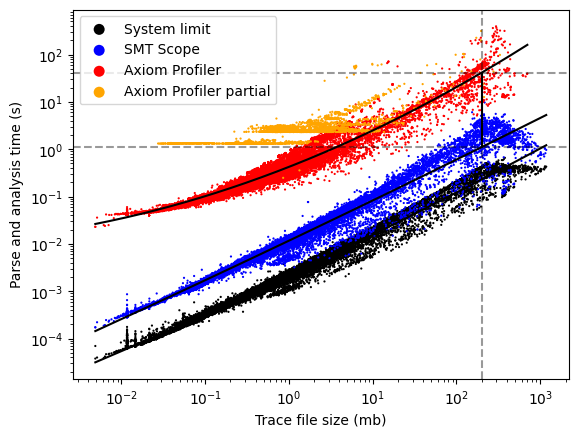

In [102]:
ap_errs = { "exs": [], "eys": [] }
plots = {}
fit_lines = {}

sizescale = 1024 * 1024
timescale = 1000 * 1000

# tools = ["z3", "dummy", "smt-scope", "axiom-profiler"]
tools = ["dummy", "smt-scope", "axiom-profiler"]

for tool in tools:
    plots[tool] = { "xs": [], "ys": [] }
    plots_tool = plots[tool]
    for dir in benchmarks:
        dir_data = all_data[dir]
        print(f"Processing {dir}")
        # ap = { "xs": [], "ys": [], "exs": [], "eys": [] }
        # ss = { "xs": [], "ys": [] }
        for file, data in dir_data.items():
            size = data["log_size"]
            for step in ["parse", "graph", "analysis"]:
                if tool == "z3":
                    if step != "parse":
                        continue
                    tool_data = { "time": data["z3_time"] }
                    tool_parse = {}
                else:
                    if not tool in data:
                        print(f"Missing {tool} in {file}:\n{data}")
                        assert False
                    if not step in data[tool]:
                        continue
                    tool_data = data[tool][step]
                    tool_parse = data[tool]["parse"]
                this_size = size
                if "err" in tool_parse:
                    assert tool == "axiom-profiler"
                    this_size *= data[tool]["parse"]["err"]
                    xs = ap_errs["exs"]
                    ys = ap_errs["eys"]
                else:
                    xs = plots_tool["xs"]
                    ys = plots_tool["ys"]
                if step == "parse":
                    xs.append(this_size / sizescale)
                    ys.append(tool_data["time"] / timescale)
                else:
                    ys[-1] += tool_data["time"] / timescale
            # if tool == "smt-scope":
            #     min_time = np.exp(fit_lines["dummy"](np.log(size / sizescale)))
            #     if min_time / 2 > plots_tool["ys"][-1]:
            #         print(f"Warning: {file} {min_time} {plots_tool['ys'][-1]}")
    
    # Fit a best fit line to the ap["xs"]/ap["ys"] dots using `polyfit`
    # and plot the line using `plot`
    plots_tool["log"] = { "xs": np.log(plots_tool["xs"]), "ys": np.log(plots_tool["ys"]) }
    fit_poly = 2# if tool == "axiom-profiler" else 1
    points_line = np.poly1d(np.polyfit(plots_tool["log"]["xs"], plots_tool["log"]["ys"], fit_poly))
    fit_lines[tool] = points_line

# Plot the time taken to parse each file as a scatter plot
# x-axis: size of the log file, y-axis: time taken to parse the log file
# there should be two types of points (one for axiom-profiler and one for smt-scope)
fig, ax = plt.subplots()
marker_size = 10
marker_shape = "."
marker_edgecolors = "none"

for tool in tools:
    points = plots[tool]
    match tool:
        case "dummy":
            color = "black"
            label = "System limit"
        case "smt-scope":
            color = "blue"
            label = "SMT Scope"
        case "axiom-profiler":
            color = "red"
            label = "Axiom Profiler"
        case "z3":
            color = "green"
            label = "Z3"
    print(f"Plotting {tool} {len(points['xs'])} points")
    ax.scatter(points["xs"], points["ys"], color=color, label=label, s=marker_size, marker=marker_shape, edgecolors=marker_edgecolors)
    points_line = fit_lines[tool]
    ax.plot(np.unique(points["xs"]), np.exp(points_line(np.unique(points["log"]["xs"]))), color="black")
if len(ap_errs["exs"]) > 0:
    ax.scatter(ap_errs["exs"], ap_errs["eys"], color="orange", label="Axiom Profiler partial", s=marker_size, marker=marker_shape, edgecolors=marker_edgecolors)

interest = 200
ap_interest = np.exp(fit_lines["axiom-profiler"](np.log(interest)))
ss_interest = np.exp(fit_lines["smt-scope"](np.log(interest)))
du_interest = np.exp(fit_lines["dummy"](np.log(interest)))
print(f"Interest point: {interest}mb, ap: {ap_interest}s, ss: {ss_interest}s, du: {du_interest}s")
max_smt_scope = max(plots["smt-scope"]["ys"])
print(f"Max smt-scope: {max_smt_scope}s")
plt.axvline(interest, color="black", linestyle="dashed", alpha=0.4)
plt.axhline(ap_interest, color="black", linestyle="dashed", alpha=0.4)
plt.axhline(ss_interest, color="black", linestyle="dashed", alpha=0.4)
plt.plot([interest, interest], [ss_interest, ap_interest], color="black")


ax.set_xlabel("Trace file size (mb)")
ax.set_ylabel(f"Parse and analysis time (s)")
# ax.set_title(f"Time")
# Set x-axis to log base 2 scale
ax.set_xscale('log')#, base=2)
ax.set_yscale('log')
lgnd = ax.legend(markerscale=5)
plt.savefig(f"./data_other/{version}/all.pdf")
plt.show()

In [99]:
def check_contained(quant_seq, loops):
    return set(quant_seq) in loops

total = 0
true_matching_loops = 0
false_matching_loops = 0
branching_count = 0
z3_time_sum = 0
ss_time_sum = 0
for dir in benchmarks:
    dir_data = all_data[dir]
    print(f"Processing {dir}")
    unique_true_loops = []
    true_loops_files = []
    unique_false_loops = []
    unique_branching = {}
    unique_top_loops = {}
    z3_time = 0
    ss_time = 0
    for file, data in dir_data.items():
        z3_time += data["z3_time"]
        ss_time += data["smt-scope"]["parse"]["time"] + data["smt-scope"]["graph"]["time"] + data["smt-scope"]["analysis"]["time"]
        for quant, mult in data["smt-scope"]["branching"]:
            quant = quant.split("[")
            assert len(quant) == 2
            quant = quant[0]
            if not quant in unique_branching:
                unique_branching[quant] = (mult, file)
                branching_count += 1
            elif mult > unique_branching[quant][0]:
                unique_branching[quant] = (mult, file)
            # else:
            #     print(f"Duplicate branching {quant}")
        if "loops" in data["smt-scope"]:
            loops = data["smt-scope"]["loops"]
            for reps,loop in loops["true"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                # if any([l.startswith("qp.") for l in loop]):
                #     continue
                if not check_contained(loop, unique_true_loops):
                    # print(f"{loop} {reps} {file}")
                    unique_true_loops.append(set(loop))
                    unique_top_loops[frozenset(loop)] = (reps, file)
                    true_loops_files.append(file)
                    true_matching_loops += 1
                elif reps > unique_top_loops[frozenset(loop)][0]:
                    unique_top_loops[frozenset(loop)] = (reps, file)
                # else:
                #     print(f"Duplicate true loop {loop}")
            for reps,loop in loops["false"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_false_loops):
                    # print(f"FALSE {loop} {reps} {file}")
                    unique_false_loops.append(set(loop))
                    false_matching_loops += 1
                # else:
                #     print(f"Duplicate false loop {loop}")
    top_branching = sorted(unique_branching.items(), key=lambda x: x[1][0], reverse=True)
    # print(f"Top branching")
    # for (quant, (mult, file)) in top_branching[:15]:
    #     print(f"{quant} {mult} {file}")
    # top_loops = sorted(unique_top_loops.items(), key=lambda x: x[1][0], reverse=True)
    # print(f"Top loops")
    # for (loop, (reps, file)) in top_loops[:15]:
    #     print(f"{loop} {reps} {file}")

    # print(f"{dir} items: {len(dir_data.items())}, true loops: {len(unique_true_loops)}, false loops: {len(unique_false_loops)}, branching: {len(unique_branching)}")
    total += len(dir_data)
    print(f"{dir.capitalize()} & {len(dir_data)} & {len(unique_true_loops)} & {len(unique_false_loops)} & {len(unique_branching)} & {int(100*ss_time/z3_time)}% \\\\")
    # for file, loop in zip(true_loops_files, unique_true_loops):
    #     print(f"{file} {loop}")
    z3_time_sum += z3_time
    ss_time_sum += ss_time
print(f"Total & {total} & {true_matching_loops} & {false_matching_loops} & {branching_count} & {int(100*ss_time_sum/z3_time_sum)}% \\\\")

Processing dafny
Dafny & 13153 & 30 & 25 & 168 & 41% \\
Processing silicon
Silicon & 2724 & 31 & 13 & 424 & 23% \\
Processing carbon
Carbon & 4774 & 11 & 8 & 1067 & 22% \\
Processing fstar
Fstar & 755 & 4 & 2 & 61 & 33% \\
Processing verus
Verus & 2581 & 2 & 2 & 15 & 11% \\
Processing smt-comp
Smt-comp & 5465 & 5 & 5 & 52 & 33% \\
Total & 29452 & 83 & 55 & 1787 & 30% \\


# Multiplicative manual
### prog.equalConsCons{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/all/issues/silicon/0045.vpr:198
Bijective axiom, trigger inference
### ring-insert.vpr@571@14@571@35 at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/graphs/static/examples/ring-insert.vpr:543
User written multiplicative quant (x2)
### prog.issubtype_exclusion{0} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/nagini/testsfunctionalverificationtest_iterator_set.py.vpr:125
Subtype encoding
### prog.$w_mul_monotonicity_1{0} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/vyper/testsresourcesexamplesstableswap_get_virtual_price.vy.vpr:190
Integer mul inequality encoding (x3)
### prog.equalSuccessorSuccessor{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/all/issues/silicon/0045.vpr:46
Bijective axiom, trigger inference
### k!547{0} at eval/smt-logs/viper/viperserver/silicon/src/main/resources/dafny_axioms/sequences.vpr:63
Internal seq axiom, problematic multi-pattern
### framing2.vpr@380@13@380@117-aux{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/graphs/static/tests/lists/framing2.vpr:380
User written multiplicative quant, trigger inference
### qp.$FVF<next>-eq-outer{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/graphs/static/examples/ring-insert.vpr
Quantified permissions
### linked-list-qp-append.vpr@16@8@16@126{6} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/quantifiedpermissions/sequences/linked-list-qp-append.vpr:16
User written multiplicative quant, trigger inference
### Student_undecided-rcvrInj{0} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/nagini/testsfunctionalverificationexamplestest_student_enroll_preds.py.vpr:567
Predicate injectivity check
### prog.issubtype_exclusion_propagation{0} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/nagini/testssifverificationtest_lowval.py.vpr:125
Subtype encoding
### array_problem.vpr@15@11@15@99{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/quantifiedpermissions/third_party/array_problem.vpr:15
User written multiplicative quant, trigger inference

# Top loops manual
### prog.numberOfElem{1} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/termination/functions/basic/adt.vpr:37
User written, trigger inference
### unionfind.vpr@116@6@116@66{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/quantifiedpermissions/sets/unionfind.vpr:116
User written, trigger inference (qp)
### quant-u-24195{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/all/issues/silicon/0365.vpr:13
Termination
### quant-u-26649{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/termination/functions/basic/postsCheck.vpr:30
Termination
### block_array.vpr@50@9@50@157-aux{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/quantifiedpredicates/issues/block_array.vpr:50
User written, trigger inference (unfolding)
### lseg.vpr@55@14@55@119{0} & quant-u-21938{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/all/predicates/lseg.vpr:55
Limited function + user written
### k!850{0} & k!859{0} at eval/smt-logs/viper/viperserver/silicon/src/main/resources/dafny_axioms/maps.vpr:95 & 108
Internal map axiom
### quant-u-472{0} & quant-u-488{1} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/prusti/with-spec-list.rs.vpr:63
Limited function
### block_array.vpr@51@9@51@161-aux{0} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/quantifiedpredicates/issues/block_array.vpr:51
User written, trigger inference (unfolding)
### quant-u-14893{0} & car-invOfFct{0} & graph_mark.vpr@195@13@195@21{1} at eval/smt-logs/viper/viperserver/silicon/silver/src/test/resources/graphs/static/examples/graph_mark.vpr:195
QP + user written (x3)
### knapsack.rs.vpr@3440@2446@3440@3044{0} & quant-u-103{0} at eval/smt-logs/viper/viperserver/silicon/src/test/resources/frontends/prusti/knapsack.rs.vpr:3440
Limited function + user written

In [86]:
def check_contained(quant_seq, loops):
    return set(quant_seq) in loops

total = 0
true_matching_loops = 0
false_matching_loops = 0
branching_count = 0
z3_time_sum = 0
ap_time_sum = 0
for dir in benchmarks:
    dir_data = all_data[dir]
    print(f"Processing {dir}")
    unique_true_loops = []
    true_loops_files = []
    unique_false_loops = []
    unique_branching = []
    z3_time = 0
    ap_time = 0
    for file, data in dir_data.items():
        if "exception" in data["axiom-profiler"]:
            unique_branching.append(data["axiom-profiler"]["exception"])
            # assert not "parse" in data["axiom-profiler"]
            # print(f"File size: {data['log_size'] / 1024 / 1024}mb")
        elif not "parse" in data["axiom-profiler"]:
            assert False
            unique_branching.append("Err")
        elif "err" in data["axiom-profiler"]["parse"]:
            unique_branching.append(data["axiom-profiler"]["parse"]["err"])
        elif "err" in data["axiom-profiler"]["analysis"]:
            unique_branching.append(data["axiom-profiler"]["analysis"]["err"])
        elif "err" in data["axiom-profiler"]["graph"]:
            unique_branching.append(data["axiom-profiler"]["graph"]["err"])
        else:
            z3_time += data["z3_time"]
            ap_time += data["axiom-profiler"]["parse"]["time"] + data["axiom-profiler"]["graph"]["time"] + data["axiom-profiler"]["analysis"]["time"]

        if "loops" in data["axiom-profiler"]:
            loops = data["axiom-profiler"]["loops"]
            for reps,loop in loops["true"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_true_loops):
                    # print(f"{loop} {reps} {file}")
                    unique_true_loops.append(set(loop))
                    true_loops_files.append(file)
                    true_matching_loops += 1
                # else:
                #     print(f"Duplicate true loop {loop}")
            for reps,loop in loops["false"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_false_loops):
                    unique_false_loops.append(set(loop))
                    false_matching_loops += 1
                # else:
                #     print(f"Duplicate false loop {loop}")
    # print(f"{dir} items: {len(dir_data.items())}, true loops: {len(unique_true_loops)}, false loops: {len(unique_false_loops)}, branching: {len(unique_branching)}")
    total += len(dir_data)
    branching_count += len(unique_branching)
    print(f"{dir.capitalize()} & {len(dir_data)} & {len(unique_true_loops)} & {len(unique_false_loops)} & {len(unique_branching)} & {int(100*ap_time/z3_time)}% \\\\")
    # for file, loop in zip(true_loops_files, unique_true_loops):
    #     print(f"{file} {loop}")
    z3_time_sum += z3_time
    ap_time_sum += ap_time
print(f"Total & {total} & {true_matching_loops} & {false_matching_loops} & {branching_count} & {int(100*ap_time_sum/z3_time_sum)}% \\\\")
print(100*branching_count/total)

Processing dafny
Dafny & 13152 & 6 & 7 & 3696 & 796% \\
Processing silicon
Silicon & 2724 & 4 & 0 & 772 & 143% \\
Processing carbon
Carbon & 4775 & 3 & 1 & 1276 & 388% \\
Processing fstar
Fstar & 755 & 0 & 0 & 681 & 162% \\
Processing verus
Verus & 2581 & 1 & 0 & 408 & 355% \\
Processing smt-comp
Smt-comp & 5465 & 3 & 0 & 512 & 737% \\
Total & 29452 & 17 & 8 & 7345 & 632% \\
24.938883607225314


In [87]:
def check_contained(quant_seq, loops):
    return set(quant_seq) in loops

total = 0

true_matching_loops = 0
missing_true_matching_loops = 0
bad_true_matching_loops = 0

false_matching_loops = 0
missing_false_matching_loops = 0
bad_false_matching_loops = 0
branching_count = 0
for dir in benchmarks:
    dir_data = all_data[dir]
    print(f"Processing {dir}")
    unique_true_loops = []
    unique_false_loops = []
    unique_true_loops_ap = []
    unique_false_loops_ap = []
    for file, data in dir_data.items():
        true_loops = []
        false_loops = []
        if "loops" in data["smt-scope"]:
            loops = data["smt-scope"]["loops"]
            for reps,loop_data in loops["true"]:
                loop = [x.split("[") for x in loop_data]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_true_loops):
                    unique_true_loops.append(set(loop))
                    true_loops.append([x.split("{")[0] for x in loop])
            for reps,loop_data in loops["false"]:
                loop = [x.split("[") for x in loop_data]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_false_loops):
                    unique_false_loops.append(set(loop))
                    false_loops.append([x.split("{")[0] for x in loop])

        if "loops" in data["axiom-profiler"]:
            loops = data["axiom-profiler"]["loops"]
            for reps,loop in loops["true"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_true_loops_ap):
                    assert len(loop) == 1
                    if not any([loop[0] in x for x in true_loops]):
                        print(f"AP true loop not in SMT-Scope: {loop} ({reps})")
                        print(f"True loops: {true_loops}")
                        print(f"False loops: {false_loops}")
                        print(f"File {file}")
                        # The `verus` and `carbon` loops are wrong
                        if reps <= 3 and not "verus/" in file and not "carbon/" in file and not "/testsresourcesexamplesEtherStore.vy-01.data" in file:
                            missing_true_matching_loops += 1
                        else:
                            bad_true_matching_loops += 1
                        assert reps <= 3 or "dafny/" in file
                    else:
                        true_matching_loops += 1
                    unique_true_loops_ap.append(set(loop))
            for reps,loop in loops["false"]:
                loop = [x.split("[") for x in loop]
                assert all([len(x) == 2 for x in loop])
                loop = [x[0] for x in loop]
                if not check_contained(loop, unique_false_loops_ap):
                    assert len(loop) == 1
                    if not any([loop[0] in x for x in false_loops]):
                        print(f"AP false loop not in SMT-Scope: {loop} ({reps})")
                        print(f"True loops: {true_loops}")
                        print(f"False loops: {false_loops}")
                        print(f"File {file}")
                        if reps <= 3:
                            missing_false_matching_loops += 1
                        else:
                            bad_false_matching_loops += 1
                        assert reps <= 3 or "dafny" in file
                    else:
                        false_matching_loops += 1
                    unique_false_loops_ap.append(set(loop))

    # print(f"{dir} items: {len(dir_data.items())}, true loops: {len(unique_true_loops)}, false loops: {len(unique_false_loops)}, branching: {len(unique_branching)}")
    total += len(dir_data)
    # branching_count += len(unique_branching)
    # print(f"{dir.capitalize()} & {len(dir_data)} & {len(unique_true_loops)} & {len(unique_false_loops)} & {len(unique_branching)} \\\\")
    # for file, loop in zip(true_loops_files, unique_true_loops):
    #     print(f"{file} {loop}")
print(f"Total & {total} & {true_matching_loops}/{missing_true_matching_loops}/{bad_true_matching_loops} & {false_matching_loops}/{missing_false_matching_loops}/{bad_false_matching_loops} & {branching_count} \\\\")
# print(100*branching_count/total)

Processing dafny
AP true loop not in SMT-Scope: ['DafnyPreludebpl.554:18'] ([8])
True loops: []
False loops: []
File ./data_other/github/v7/dafny/Source/IntegrationTests/TestFiles/LitTests/LitTest/c++/datatypes-Impl___module.__default.Main.data


TypeError: '<=' not supported between instances of 'list' and 'int'